In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [5]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060 Laptop GPU


Read a batch of training images along with their bounding boxes and labels

(3000, 3000, 3)


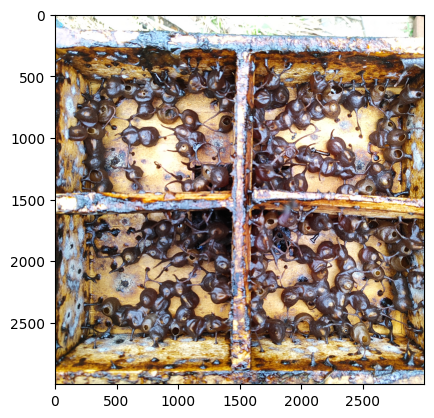

In [6]:

# Load image
img0 = cv2.imread('penelitian/gambar_1.jpg')

# Check if the image is loaded successfully
if img0 is None:
    print("Error: Unable to load image.")
else:
    # Convert BGR to RGB
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    print(img0.shape)
    plt.imshow(img0)
    plt.show()


In [7]:
bbox0 = np.array([[1090, 2700, 1200, 2850], [700, 500, 530, 670]])
labels = np.array([1,1]) 

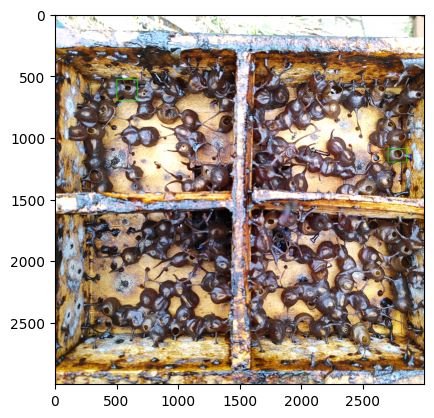

In [8]:
img0_clone = np.copy(img0)
for i in range (len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(0, 255, 0), thickness=3)
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), thickness=3)
plt.imshow(img0_clone)
plt.show()

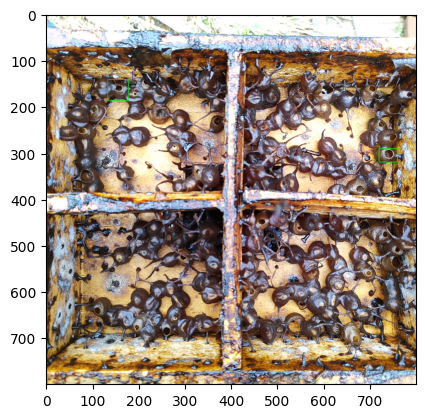

In [9]:
img = cv2.resize(img0_clone, (800, 800 ), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [10]:
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioLst)]
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[290 720 320 760]
 [186 133 141 178]]


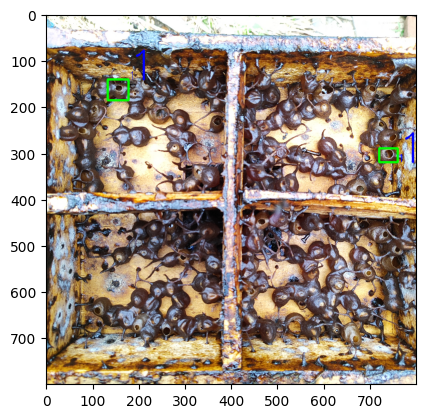

In [11]:
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range (len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3)
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness=3)
plt.imshow(img_clone)

In [12]:
model = torchvision.models.vgg16(pretrained=True). to(device)
fe = list(model.features)
print(len(fe))

c:\Users\Lenovo Gk\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo Gk\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


31


In [13]:
dummy_img = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2]<800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))
print(out_channels)

torch.Size([1, 3, 800, 800])
30
512


In [14]:
faster_rcnn_fe_exractor = nn.Sequential(*req_features)

In [15]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_exractor(imgTensor)
print(out_map.size)

<built-in method size of Tensor object at 0x0000021C74AEF9B0>


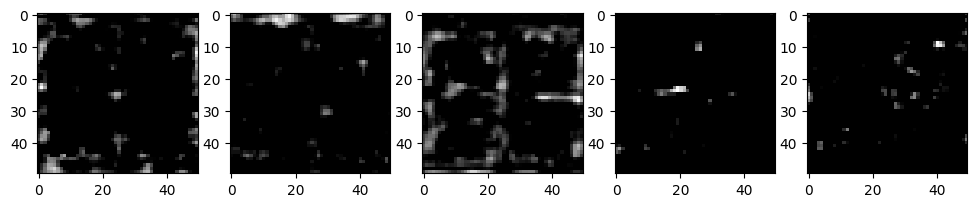

In [16]:
imgArray = out_map.data.cpu(). numpy(). squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow (imgArray[i], cmap='gray')
    figNo +=1
plt.show()

In [17]:
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1)*16, 16)
ctr_y = np.arange(16, (fe_size+1)*16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [18]:
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range (len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index += 1
print(ctr.shape)

(2500, 2)


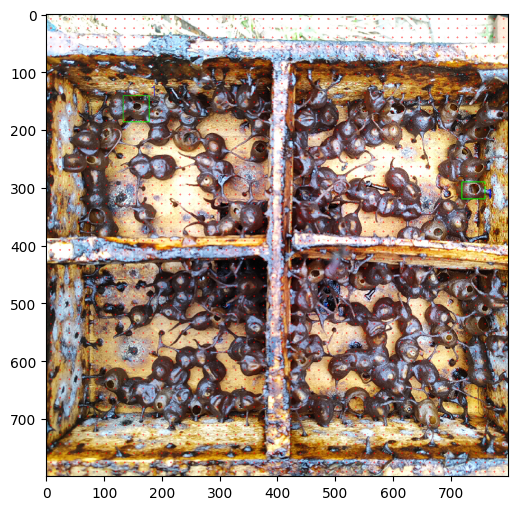

In [19]:
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]) :
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius = 1, color = (255,0,0), thickness=1)
plt.imshow(img_clone)
plt.show()

In [20]:
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4)) 
index = 0
for c in ctr:
    ctr_y, ctr_x = c 
    for i in range (len(ratios)):
        for j in range (len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index +=1
print(anchor_boxes.shape)


(22500, 4)


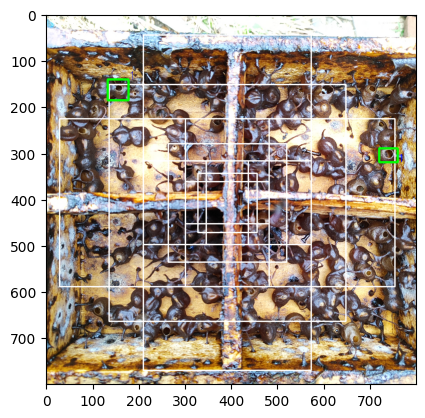

In [21]:
img_clone = np.copy(img)
for i in range (11025, 11034):
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 255), thickness=2)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

In [22]:
index_inside = np.where(
    (anchor_boxes[:, 0] >= 0)&
    (anchor_boxes[:, 1] >= 0)&
    (anchor_boxes[:, 2] <= 800)&
    (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [23]:
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 =j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = max([xb2, xa2])
        inter_y2 = max([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1)*(inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(8940, 2)


In [24]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_max_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[8920 1334]
[  2.48368 138.60803]
[8920 1334]


In [25]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 1 1 ... 0 0 0]
[0.07324219 0.0832023  0.14541525 ... 2.48368    2.48368    2.48368   ]


In [26]:
label = np.empty(((len(index_inside)), ), dtype = np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [27]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious <= neg_iou_threshold] = 0

In [28]:
n_sample = 256  # Jumlah total sampel
# pos_ratio = 0.5  # Rasio sampel positif yang diinginkan dalam dataset akhir
pos_ratio = 1
n_pos = pos_ratio * n_sample  # Jumlah sampel positif yang diinginkan

# Temukan indeks sampel positif
pos_index = np.where(label == 1)[0]

# Jika ada lebih banyak sampel positif dari yang diinginkan, nonaktifkan beberapa secara acak
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1  # Menandai sampel yang dinonaktifkan dengan -1

# Hitung jumlah sampel negatif yang diperlukan
n_neg = n_sample * np.sum(label == 1)

# Temukan indeks sampel negatif
neg_index = np.where(label == 0)[0]

# Jika ada lebih banyak sampel negatif dari yang diinginkan, nonaktifkan beberapa secara acak
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
    label[disable_index] = -1  # Menandai sampel yang dinonaktifkan dengan -1


In [29]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - base_ctr_x) / height
dx = (base_ctr_x - base_ctr_y) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)). transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


C:\Users\Lenovo Gk\AppData\Local\Temp\ipykernel_4180\3718396376.py:19: RuntimeWarning: invalid value encountered in log
  dh = np.log(base_height / height)


In [30]:
anchor_labels = np.empty((len(anchor_boxes),), dtype = label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)


anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype = anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


In [31]:
in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1). to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0). to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0). to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [32]:
x = conv1(out_map.to(device))
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [33]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1). contiguous(). view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1). contiguous()
print(pred_cls_scores.shape)

objectness_scores = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1]. contiguous(). view(1, -1,)
print(objectness_scores.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [34]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)


torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [35]:
rpn_locs = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_locs.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [36]:
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index= -1)
print(rpn_cls_loss) 

tensor(0.6804, device='cuda:0', grad_fn=<NllLossBackward0>)


In [37]:
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_locs)
print(mask.shape)

mask_loc_preds = rpn_locs[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1). float() * 0.5 * x**2) + ((x >= 1).float()*(x-0.5))
print(rpn_loc_loss.sum()) 

torch.Size([22500, 4])
torch.Size([256, 4]) torch.Size([256, 4])
tensor(nan, dtype=torch.float64, grad_fn=<SumBackward0>)


In [38]:
rpn_lambda = 10.
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(nan, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [39]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

In [40]:
# the labelled 22500 anchor boxes
# format converted from [y1, x1 , y2, x2] to [ctr_x, ctr_y, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

# the 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_scores_numpy = objectness_scores[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]
print(dy.shape)

# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500,)
(22500, 1)
(22500, 1)


In [41]:
# labelled anchor boxes RPN anchor boxes ROI = [y1, x1, y2, x2]
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype = anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

# clip the predicted boxes to image
img_size = (800,800) # image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)],0 ,img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)],0 ,img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4)
(22500, 4) 800.0 0.0


In [42]:
# remove predicted boxes with either height or widht < threshold
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_scores_numpy[keep]
print(keep.shape, roi.shape, score.shape)

# sort all(proposal, score) pairs by score from highest to lowest
order = score.ravel().argsort()[::-1]
print(order.shape)

# take top pre_nms_topN (e.g 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)

(22500,) (22500, 4) (22500,)
(22500,)
(12000,) (12000, 4) (12000, 4)


In [43]:
# take all the roi boxes [roi_array]
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

# find the areas of all the boxes [roi_area]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [44]:
# take the indexes of order the probability score in descending order
order = order.argsort()[::-1]
keep = []

while(order.size > 0):
    i = order[0] #take the 1st elt in order and append to keep
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.maximum(x2[i], x2[order[1:]])
    yy2 = np.maximum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] #while training/testing, use accordingly
roi = roi[keep] #the final region proposals
print(len(keep), roi.shape)

34 (34, 4)


In [45]:
n_sample = 128 #number of samples from roi
pos_ratio = 0.25 #number of positive examples out of the n_samples
pos_iou_thresh = 0.5 #min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.5 #iou 0-0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [46]:
ious = np.empty((len(roi), 2), dtype = np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb1, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y1 = min([yb1, ya1])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_x2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(34, 2)


In [50]:
# find out which fround truth has high IoU for each region proposal, Also find maximum IoU
gt_assigment = ious.argmax(axis = 1)
max_iou = ious.max(axis = 1)
print(gt_assigment)
print(max_iou)

# Assign the labels to each proposal
gt_roi_label = labels[gt_assigment]
print(gt_roi_label)

[0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.38695148 0.         0.5889954  0.4346516  0.         0.
 0.         0.         3.2856033  0.29218736 0.23853958 0.
 0.         1.9145812  0.21493806 1.2854398  0.24834412 0.30954975
 0.         0.         0.         1.9941502  1.4309497  0.12663338
 0.16707598 0.1223832  0.24079362 2.4054012  0.11924347 0.
 0.090316   0.14800833 0.08001734 0.19867533]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [55]:
# select the foreground rois as per the pos_iou_thesh and
# n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size = pos_roi_per_this_image, replace = False
    )
print(pos_roi_per_this_image)
print(pos_index)

# similarly we do for negative (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) & 
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if neg_index.size > 0:
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False
    )
    print(neg_roi_per_this_image)
    print(neg_index)

7
[22 15 13  2 21  8 27]
27
[12  3 19 23 24 18 33 20  4 32 26 16 30 17 25  0  5 29 28  9  6  7 31 10
 11  1 14]


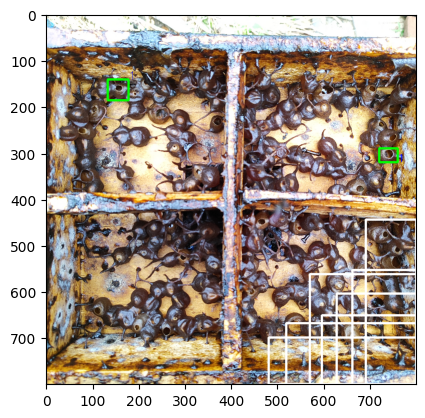

In [52]:
# display roi samples with postive

img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]]. astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1,y1), color=(255, 255, 255), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0,), thickness = 3)

plt.imshow(img_clone)
plt.show()